In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 500)

C:\Users\can2hr\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\can2hr\Anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
def split_data(data, tackles):
    for name in tackles:
        tackle = data[data['tackle_name'] == name]
        train_x = pd.DataFrame()
        test_x = pd.DataFrame()
        train_y = pd.DataFrame()
        test_y = pd.DataFrame()
        if len(tackle) > 25:
            tackle_x = tackle.drop(['one_sec_dist'], axis = 1)
            tackle_y = tackle[tackle['one_sec_dist']]
            x_train,x_test,y_train,y_test=train_test_split(tackle_x,tackle_y,test_size=0.2, random_state = 1029)
            train_x = pd.concat([train_x, x_train])
            test_x = pd.concat([test_x, x_test])
            train_y = pd.concat([train_y, y_train])
            test_y = pd.concat([test_y, y_test])
    return train_x, test_x, train_y, test_y

## Speed
Our response will be predicted get off time
    - Need to decide how we want to do this
    - Option 1 is amount of time to get to a certain distance (Say 1.5 yards)
    - Option 2 would be predicted yards given a cetain amount of time
For predictors:
    - Height/weight of the tackle
    - Quarter
    - Whether it's an obvious passing situation
    - Left vs right tackle?

## Power
Our response here is some variation of percentage of the distance to the QB given up once engaged with the defensive end
For predictors:
    - Height/weight of both the tackle and the end
    - Obvious passing situation
    - Time to throw for the QB
    - Quarter

In [3]:
model_data = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/clustered.csv')

In [4]:
model_data.columns

Index(['uniqueplayId', 'QB_Flip', 'rushType', 'Power_prob', 'Speed_prob',
       'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'playDirection', 'event', 'ball_snap_frame', 'end_frame',
       'play_length_frames', 'Right_end', 'Left_end', 'QB_nflId',
       'QB_jerseyNumber', 'QB_team', 'QB_x', 'QB_y', 'QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp',
       'QB_pff_nflIdBlockedPlayer', 'QB_pff_blockType', 'QB_new_x', 'QB_new_y',
       'ball_nflId', 'ball_jerseyNumber', 'ball_team', 'ball_x', 'ball_y',
       'ball_s', 'ball_a', 'ball_dis', 'ball_o', 'ball_dir', 'ball_pff_role',
       'ball_pff_positionLinedUp', 'ball_pff_nflIdBlockedPlayer',
       'ball_pff_blockType', 'ball_new_x', 'ball_new_y', 'ball_Flip',
       'Tackle_nflId', 'Tackle_jerseyNumber', 'Tackle_team', 'Tackle_x',
       'Tackle_y', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLined

In [5]:
model_data2 = model_data[['uniqueplayId','QB_Flip','rushType','Power_prob','Speed_prob',
            'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'event','play_length_frames','QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp','QB_new_x', 'QB_new_y',
            'ball_new_x', 'ball_new_y', 'ball_Flip','ball_snap_frame',
       'Tackle_nflId', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLinedUp',
       'Tackle_pff_nflIdBlockedPlayer', 'Tackle_pff_blockType', 'Tackle_new_x',
       'Tackle_new_y', 'Tackle_Flip', 'End_nflId', 'End_s', 'End_a', 'End_dis', 'End_o',
       'End_dir', 'End_pff_role', 'End_pff_positionLinedUp', 'End_new_x',
       'End_new_y', 'End_Flip', 'tackle_end_dist', 'tackle_end_facing']]

In [6]:
players = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/players.csv')

In [7]:
players = players[['height', 'weight', 'nflId','displayName']]

In [8]:
model_data3 = model_data2.merge(players, left_on = 'Tackle_nflId', right_on = 'nflId', how = 'left')

In [9]:
model_data4 = model_data3.rename(columns = {'height':'tackle_height','weight':'tackle_weight','displayName':'tackle_name'}).drop('nflId', axis = 1)

In [10]:
model_data5 = model_data4.merge(players, left_on = 'End_nflId', right_on = 'nflId', how = 'left')

In [11]:
model_data6 = model_data5.rename(columns = {'height':'end_height','weight':'end_weight','displayName':'end_name'}).drop('nflId', axis = 1)

In [12]:
plays = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')

In [13]:
plays['obvious_pass'] = ((plays['down'] == 2) & (plays['yardsToGo'] > 10)) | ((plays['down'] == 3) & (plays['yardsToGo'] > 4)) | ((plays['down'] == 4) & (plays['yardsToGo'] > 2))

In [14]:
plays['obvious_pass'] = plays['obvious_pass'].astype(int)

In [15]:
plays = plays[['gameId','playId','quarter','obvious_pass']]

In [16]:
plays

,gameId,playId,quarter,obvious_pass
0,2021090900,97,1,0
1,2021090900,137,1,0
2,2021090900,187,1,0
3,2021090900,282,1,0
4,2021090900,349,1,1
...,...,...,...,...
8553,2021110100,4310,4,1
8554,2021110100,4363,4,0
8555,2021110100,4392,4,0
8556,2021110100,4411,4,1


In [17]:
model_data7 = model_data6.merge(plays, on = ['gameId','playId'], how = 'left')

In [18]:
model_data7['tackle_end_engaged'] = (model_data7['tackle_end_facing'] <= 40) & (model_data7['tackle_end_dist'] <= 1)

In [19]:
model_data7['tackle_end_engaged'] = model_data7['tackle_end_engaged'].astype(int)

In [20]:
model_data7['tackle_end_engaged'].value_counts()

0    201295
1     50412
Name: tackle_end_engaged, dtype: int64

In [21]:
def dist(x_1, y_1, x_2, y_2):
    return np.sqrt(np.sum([(x_1-x_2)**2, (y_1-y_2)**2], axis=0))

In [22]:
model_data7['tackle_qb_dist'] = dist(model_data7['Tackle_new_x'], model_data7['Tackle_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [23]:
model_data7['end_qb_dist'] = dist(model_data7['End_new_x'], model_data7['End_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [24]:
speed = model_data7[model_data7['rushType'] == 'Speed']
speed

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,tackle_weight,tackle_name,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist
66,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,6,...,320,Dion Dawkins,6-4,242,Alex Highsmith,1,0,0,4.820290,7.786174
67,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,7,...,320,Dion Dawkins,6-4,242,Alex Highsmith,1,0,0,4.816638,7.779460
68,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,8,...,320,Dion Dawkins,6-4,242,Alex Highsmith,1,0,0,4.790918,7.744837
69,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,9,...,320,Dion Dawkins,6-4,242,Alex Highsmith,1,0,0,4.766424,7.654672
70,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,10,...,320,Dion Dawkins,6-4,242,Alex Highsmith,1,0,0,4.738143,7.531268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251702,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,20,...,325,Bobby Massie,6-4,315,Jordan Elliott,3,0,0,4.995968,6.031923
251703,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,21,...,325,Bobby Massie,6-4,315,Jordan Elliott,3,0,0,5.045909,6.051859
251704,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,22,...,325,Bobby Massie,6-4,315,Jordan Elliott,3,0,0,5.093447,6.079753
251705,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,23,...,325,Bobby Massie,6-4,315,Jordan Elliott,3,0,0,5.107886,6.099746


In [25]:
power = model_data7[model_data7['rushType'] == 'Power']

In [26]:
subset = power[power['tackle_end_engaged'] == 1]

In [27]:
subset2 = subset.groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [28]:
distance_when_engaged = subset2[['uniqueplayId','QB_Flip','tackle_qb_dist']]
distance_when_engaged

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109090097,0.0,3.408724
1,202109190555,1.0,2.828569
2,202109190595,1.0,4.166353
3,202109190975,0.0,3.489327
4,202109260199,0.0,5.214873
...,...,...,...
949,20211025002455,0.0,4.942398
950,20211025003506,0.0,6.018937
951,20211025003536,1.0,5.358591
952,20211025003660,0.0,4.320046


In [29]:
end_distance = model_data7.groupby(['uniqueplayId','QB_Flip']).last().reset_index()

In [30]:
end_distance = end_distance[['uniqueplayId','QB_Flip','tackle_qb_dist']]
end_distance

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109090097,0.0,3.197890
1,202109090097,1.0,2.797803
2,202109120163,0.0,3.003265
3,202109120163,1.0,4.141618
4,202109120288,0.0,4.306948
...,...,...,...
9091,20211025003684,1.0,2.564995
9092,20211025003904,0.0,2.465218
9093,20211025003904,1.0,3.892364
9094,20211025003926,0.0,7.646829


In [31]:
end_distance = end_distance.rename(columns = {'tackle_qb_dist': 'ending_distance'})

In [32]:
distance = distance_when_engaged.merge(end_distance, on = ['uniqueplayId', 'QB_Flip'], how = 'left')
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance
0,202109090097,0.0,3.408724,3.197890
1,202109190555,1.0,2.828569,4.932839
2,202109190595,1.0,4.166353,1.932589
3,202109190975,0.0,3.489327,4.919268
4,202109260199,0.0,5.214873,1.878776
...,...,...,...,...
949,20211025002455,0.0,4.942398,9.519417
950,20211025003506,0.0,6.018937,2.628003
951,20211025003536,1.0,5.358591,3.910051
952,20211025003660,0.0,4.320046,2.471680


In [33]:
distance['pct_given_up'] = (distance['tackle_qb_dist'] - distance['ending_distance']) / distance['tackle_qb_dist']
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance,pct_given_up
0,202109090097,0.0,3.408724,3.197890,0.061851
1,202109190555,1.0,2.828569,4.932839,-0.743935
2,202109190595,1.0,4.166353,1.932589,0.536144
3,202109190975,0.0,3.489327,4.919268,-0.409804
4,202109260199,0.0,5.214873,1.878776,0.639727
...,...,...,...,...,...
949,20211025002455,0.0,4.942398,9.519417,-0.926072
950,20211025003506,0.0,6.018937,2.628003,0.563378
951,20211025003536,1.0,5.358591,3.910051,0.270321
952,20211025003660,0.0,4.320046,2.471680,0.427858


In [34]:
distance = distance.rename(columns = {'tackle_qb_dist' : 'starting_distance'})

In [35]:
model_data8 = model_data7.merge(distance, on = ['uniqueplayId','QB_Flip'], how = 'left')
model_data8

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,starting_distance,ending_distance,pct_given_up
0,202109090097,0.0,Power,0.81578,0.18422,41.56,23.92,2021090900,97,6,...,255,Randy Gregory,1,0,0,4.589466,10.452009,3.408724,3.19789,0.061851
1,202109090097,0.0,Power,0.81578,0.18422,41.56,23.92,2021090900,97,7,...,255,Randy Gregory,1,0,0,4.590697,10.450000,3.408724,3.19789,0.061851
2,202109090097,0.0,Power,0.81578,0.18422,41.56,23.92,2021090900,97,8,...,255,Randy Gregory,1,0,0,4.592004,10.358002,3.408724,3.19789,0.061851
3,202109090097,0.0,Power,0.81578,0.18422,41.56,23.92,2021090900,97,9,...,255,Randy Gregory,1,0,0,4.572800,10.242095,3.408724,3.19789,0.061851
4,202109090097,0.0,Power,0.81578,0.18422,41.56,23.92,2021090900,97,10,...,255,Randy Gregory,1,0,0,4.552296,9.912906,3.408724,3.19789,0.061851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251702,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,20,...,315,Jordan Elliott,3,0,0,4.995968,6.031923,NaN,NaN,NaN
251703,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,21,...,315,Jordan Elliott,3,0,0,5.045909,6.051859,NaN,NaN,NaN
251704,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,22,...,315,Jordan Elliott,3,0,0,5.093447,6.079753,NaN,NaN,NaN
251705,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,23,...,315,Jordan Elliott,3,0,0,5.107886,6.099746,NaN,NaN,NaN


In [36]:
## Going to need to remove any power plays where this is an NA
model_data8 = model_data8.dropna(subset = ['pct_given_up'])

In [37]:
speed['dist_moved'] = speed.groupby(['uniqueplayId','QB_Flip'])['Tackle_dis'].cumsum()

<ipython-input-37-e5681bf5ed00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed['dist_moved'] = speed.groupby(['uniqueplayId','QB_Flip'])['Tackle_dis'].cumsum()


In [38]:
one_yard = speed[speed['dist_moved'] >= 1].groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [39]:
one_yard = one_yard[['uniqueplayId','QB_Flip','frameId','ball_snap_frame']]

In [40]:
one_yard['tackle_get_off_time'] = (one_yard['frameId'] - one_yard['ball_snap_frame'])*.1

In [41]:
get_off = one_yard[['uniqueplayId','QB_Flip','tackle_get_off_time']]

In [42]:
speed2 = speed.merge(get_off, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [43]:
speed2

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time
0,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,6,...,6-4,242,Alex Highsmith,1,0,0,4.820290,7.786174,0.03,0.7
1,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,7,...,6-4,242,Alex Highsmith,1,0,0,4.816638,7.779460,0.09,0.7
2,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,8,...,6-4,242,Alex Highsmith,1,0,0,4.790918,7.744837,0.19,0.7
3,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,9,...,6-4,242,Alex Highsmith,1,0,0,4.766424,7.654672,0.33,0.7
4,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,10,...,6-4,242,Alex Highsmith,1,0,0,4.738143,7.531268,0.49,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186954,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,20,...,6-4,315,Jordan Elliott,3,0,0,4.995968,6.031923,1.98,0.8
186955,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,21,...,6-4,315,Jordan Elliott,3,0,0,5.045909,6.051859,2.19,0.8
186956,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,22,...,6-4,315,Jordan Elliott,3,0,0,5.093447,6.079753,2.41,0.8
186957,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,23,...,6-4,315,Jordan Elliott,3,0,0,5.107886,6.099746,2.63,0.8


In [44]:
## Now looking at yards traveled in the first second
one_sec = speed2[speed2['frameId'] == speed2['ball_snap_frame'] + 10]
one_sec = one_sec[['uniqueplayId','QB_Flip','dist_moved']].rename(columns = {'dist_moved':'one_sec_dist'})

In [45]:
speed3 = speed2.merge(one_sec, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [46]:
speed3

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time,one_sec_dist
0,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,6,...,242,Alex Highsmith,1,0,0,4.820290,7.786174,0.03,0.7,1.95
1,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,7,...,242,Alex Highsmith,1,0,0,4.816638,7.779460,0.09,0.7,1.95
2,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,8,...,242,Alex Highsmith,1,0,0,4.790918,7.744837,0.19,0.7,1.95
3,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,9,...,242,Alex Highsmith,1,0,0,4.766424,7.654672,0.33,0.7,1.95
4,202109120163,0.0,Speed,0.03532,0.96468,34.03,23.76,2021091201,63,10,...,242,Alex Highsmith,1,0,0,4.738143,7.531268,0.49,0.7,1.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186954,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,20,...,315,Jordan Elliott,3,0,0,4.995968,6.031923,1.98,0.8,1.38
186955,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,21,...,315,Jordan Elliott,3,0,0,5.045909,6.051859,2.19,0.8,1.38
186956,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,22,...,315,Jordan Elliott,3,0,0,5.093447,6.079753,2.41,0.8,1.38
186957,20211021002175,1.0,Speed,NaN,NaN,92.41,29.85,2021102100,2175,23,...,315,Jordan Elliott,3,0,0,5.107886,6.099746,2.63,0.8,1.38


In [47]:
one_sec_dist_df = speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['one_sec_dist'].unique()[0]).reset_index().rename(columns={0:'one_sec_dist'})

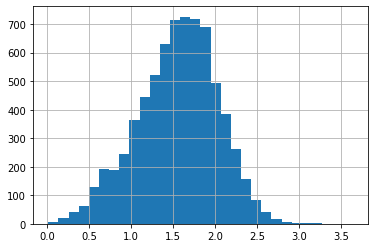

In [48]:
one_sec_dist_df['one_sec_dist'].hist(bins=30);

In [49]:
speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['end_name'].unique()[0]).reset_index().rename(columns={0:'end_name'})['end_name'].value_counts()[0:50]

Chase Young            92
Yannick Ngakoue        91
Montez Sweat           91
Emmanuel Ogbah         90
Maxx Crosby            82
Odafe Oweh             81
Rashan Gary            77
Bryce Huff             77
Leonard Floyd          77
Jaelan Phillips        75
Shaquil Barrett        75
Danielle Hunter        75
Sam Hubbard            74
Cameron Jordan         72
Trey Hendrickson       72
Malik Reed             71
Chandler Jones         70
Brian Burns            67
Justin Houston         66
Markus Golden          65
Aaron Donald           64
Azeez Ojulari          63
Jason Pierre-Paul      62
Josh Sweat             62
Preston Smith          62
Carlos Dunlap          61
Josh Allen             60
Charles Harris         59
Von Miller             56
Melvin Ingram          56
Joey Bosa              55
Haason Reddick         54
John Franklin-Myers    54
Everson Griffen        54
Matt Judon             52
Lorenzo Carter         52
Dawuane Smoot          51
Alex Highsmith         51
Al-Quadin Mu

In [50]:
speed3[speed3['end_name'] == 'Harold Landry']['uniqueplayId'].value_counts()

Series([], Name: uniqueplayId, dtype: int64)

In [51]:
play = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')

In [52]:
play['uniqueplayId'] = play['gameId'].astype(str) + play['playId'].astype(str)

In [53]:
play[play['uniqueplayId'].isin(['2021102405360','20211018002346','20210912071703','20211010043914','20211010043129'])]

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,uniqueplayId
656,2021091207,1703,(6:50) (Shotgun) K.Murray pass incomplete deep...,2,1,10,ARI,TEN,ARI,25,...,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,20210912071703
4885,2021101004,3129,(12:21) (Shotgun) T.Lawrence pass deep left to...,4,1,10,JAX,TEN,JAX,30,...,80.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,1,Cover-2,Zone,20211010043129
4899,2021101004,3914,"(:31) (No Huddle, Shotgun) T.Lawrence pass sho...",4,3,1,JAX,TEN,JAX,48,...,62.0,EMPTY,"1 RB, 1 TE, 3 WR",4.0,"3 DL, 2 LB, 6 DB",TRADITIONAL,0,Cover-3,Zone,20211010043914
6574,2021101800,2346,"(12:41) (No Huddle, Shotgun) J.Allen pass shor...",3,1,10,BUF,TEN,BUF,44,...,66.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,20211018002346
7061,2021102405,360,(10:21) (Shotgun) P.Mahomes pass short right t...,1,2,5,KC,TEN,KC,30,...,80.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,2021102405360


In [54]:
power_speed_perc = model_data7.groupby(['end_name', 'uniqueplayId', 'QB_Flip']).agg({
    'rushType':'first'
}).reset_index().groupby('end_name')['rushType'].agg(
    power_perc = lambda x: x[x == 'Power'].count()/x.count(),
    speed_perc = lambda x: x[x == 'Speed'].count()/x.count(),
    total = 'count'
).reset_index()

In [55]:
overall_perc_avs = model_data7.groupby(['uniqueplayId', 'QB_Flip']).agg({
    'rushType':'first'
}).reset_index()['rushType'].value_counts(normalize=True)
overall_perc_avs

Speed    0.786609
Power    0.213391
Name: rushType, dtype: float64

In [56]:
power_speed_perc['Av_Power'] = overall_perc_avs[0]
power_speed_perc['Av_Speed'] = overall_perc_avs[1]
power_speed_perc['num_plays'] = power_speed_perc['total'].sum()
power_speed_perc['end_power_perc'] = power_speed_perc['power_perc']*(power_speed_perc['total']/500) + power_speed_perc['Av_Power']*(1-power_speed_perc['total']/500)
power_speed_perc['end_speed_perc'] = power_speed_perc['speed_perc']*(power_speed_perc['total']/500) + power_speed_perc['Av_Speed']*(1-power_speed_perc['total']/500)

In [68]:
power = model_data8.merge(power_speed_perc[['end_name', 'end_power_perc', 'end_speed_perc']], how='left', on='end_name')

In [57]:
speed3 = speed3.merge(power_speed_perc[['end_name', 'end_power_perc', 'end_speed_perc']], how='left', on='end_name')

In [58]:
# Aggregate for grouped by to prepare data for modeling - one row per tackle/end instance
# The row should have the distance of the tackle in one second, and multiple predictors
# The predictors are speed/power percent of the end, weight and height of end, one-hot offensive linesman, obvious passing situation, and maybe quarter
def full_agg(grouped_df):
    row = grouped_df[grouped_df['frameId']==grouped_df['ball_snap_frame']+10]
    return pd.DataFrame({
    'one_sec_dist': row['dist_moved'],
    'end_power_perc': row['end_power_perc'],
    'end_speed_perc':  row['end_speed_perc'],
    'end_height': row['end_height'],
    'end_weight': row['end_weight'],
    'tackle_name': row['tackle_name'],
    'obvious_pass': row['obvious_pass'],
    'quarter': row['quarter']
})

speed_data = speed3.groupby(['uniqueplayId', 'QB_Flip'], group_keys=True).apply(full_agg).reset_index().drop(['level_2'], axis=1)
speed_data

,uniqueplayId,QB_Flip,one_sec_dist,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter
0,202109120163,0.0,1.95,0.712777,0.287223,6-4,242,Dion Dawkins,0,1
1,202109120163,1.0,2.18,0.731070,0.268930,6-4,252,Daryl Williams,0,1
2,202109120288,1.0,1.40,0.688886,0.311114,6-5,250,George Fant,0,1
3,202109120578,1.0,0.76,0.774024,0.225976,6-5,294,Marcus Cannon,0,1
4,202109120676,0.0,1.30,0.728961,0.271039,6-2,270,Julien Davenport,0,1
...,...,...,...,...,...,...,...,...,...,...
7150,20211025003660,1.0,1.49,0.728961,0.271039,6-2,270,Ryan Ramczyk,1,4
7151,20211025003904,0.0,2.07,0.765011,0.234989,6-6,265,Duane Brown,0,4
7152,20211025003904,1.0,1.86,0.680166,0.319834,6-4,287,Brandon Shell,0,4
7153,20211025003926,0.0,0.83,0.765011,0.234989,6-6,265,Duane Brown,0,4


In [59]:
speed_data['end_height'] = [int(j)*12+int(i) for j, i in speed_data['end_height'].str.split('-')]

In [60]:
speed_data

,uniqueplayId,QB_Flip,one_sec_dist,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter
0,202109120163,0.0,1.95,0.712777,0.287223,76,242,Dion Dawkins,0,1
1,202109120163,1.0,2.18,0.731070,0.268930,76,252,Daryl Williams,0,1
2,202109120288,1.0,1.40,0.688886,0.311114,77,250,George Fant,0,1
3,202109120578,1.0,0.76,0.774024,0.225976,77,294,Marcus Cannon,0,1
4,202109120676,0.0,1.30,0.728961,0.271039,74,270,Julien Davenport,0,1
...,...,...,...,...,...,...,...,...,...,...
7150,20211025003660,1.0,1.49,0.728961,0.271039,74,270,Ryan Ramczyk,1,4
7151,20211025003904,0.0,2.07,0.765011,0.234989,78,265,Duane Brown,0,4
7152,20211025003904,1.0,1.86,0.680166,0.319834,76,287,Brandon Shell,0,4
7153,20211025003926,0.0,0.83,0.765011,0.234989,78,265,Duane Brown,0,4


In [61]:
tackles = speed_data['tackle_name'].unique()
len(tackles)

114

In [86]:
## Do we want to leave the tackles in the train set who don't have enough snaps to get test data? A couple need to be removed for sure since they are tight ends so I set keep if we have 5 instances
def split_data(data, tackles):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for name in tackles:
        tackle = data[data['tackle_name'] == name]
        if len(tackle) > 4:
            if len(tackle) >= 25:
                x_train,x_test = train_test_split(tackle, test_size=0.2, random_state = 1029)
                train_x = pd.concat([train_x, x_train])
                test_x = pd.concat([test_x, x_test])
            else:
                train_x = pd.concat([train_x, tackle])
    return train_x, test_x

In [81]:
train_speed, test_speed = split_data(speed_data, tackles)

In [82]:
train_speed['tackle_name'].value_counts()

Tristan Wirfs           135
Donovan Smith           132
Jake Matthews           120
Penei Sewell            119
Matt Nelson             116
Jonah Williams          112
Kolton Miller           111
Taylor Moton            104
Rashawn Slater          104
Charles Leno            103
Dan Moore               102
Isaiah Wynn             100
Andrew Whitworth        100
Liam Eichenberg          98
Riley Reiff              98
David Quessenberry       96
Garett Bolles            96
Alejandro Villanueva     96
Brian O'Neill            92
Orlando Brown            92
Bobby Massie             91
Rob Havenstein           88
Tyron Smith              87
Nate Solder              83
Cam Robinson             82
Cameron Erving           80
Jawaan Taylor            80
Storm Norton             79
Kaleb McGary             77
George Fant              76
Dion Dawkins             76
Andrew Thomas            72
Duane Brown              71
Patrick Mekari           71
Justin Herron            71
Trent Williams      

In [83]:
test_speed['tackle_name'].value_counts()

Tristan Wirfs           34
Donovan Smith           33
Penei Sewell            30
Jake Matthews           30
Matt Nelson             29
Kolton Miller           28
Jonah Williams          28
Taylor Moton            27
Rashawn Slater          27
Charles Leno            26
Dan Moore               26
Andrew Whitworth        26
David Quessenberry      25
Riley Reiff             25
Isaiah Wynn             25
Garett Bolles           25
Liam Eichenberg         25
Alejandro Villanueva    24
Orlando Brown           24
Bobby Massie            23
Brian O'Neill           23
Rob Havenstein          23
Tyron Smith             22
Nate Solder             21
Jawaan Taylor           21
Cam Robinson            21
Kaleb McGary            20
Storm Norton            20
Dion Dawkins            20
George Fant             20
Cameron Erving          20
Patrick Mekari          18
Duane Brown             18
Justin Herron           18
Andrew Thomas           18
Chukwuma Okorafor       17
Trent Williams          17
L

In [84]:
## Amount removed as is
len(speed_data) - len(train_speed) - len(test_speed)

25

In [77]:
# Aggregate for grouped by to prepare data for modeling - one row per tackle/end instance
# The row should have the perctage of the distance given up once engaged, and multiple predictors
# The predictors are speed/power percent of the end, weight and height of end, one-hot offensive linesman, obvious passing situation, starting distance, length of the play, and maybe quarter
def full_agg(grouped_df):
    row = grouped_df[grouped_df['frameId']==grouped_df['ball_snap_frame']]
    return pd.DataFrame({
    'end_power_perc': row['end_power_perc'],
    'end_speed_perc':  row['end_speed_perc'],
    'end_height': row['end_height'],
    'end_weight': row['end_weight'],
    'tackle_name': row['tackle_name'],
    'obvious_pass': row['obvious_pass'],
    'quarter': row['quarter'],
    'pct_given_up': row['pct_given_up'],
    'starting_distance': row['starting_distance'],
    'play_length': row['play_length_frames']
})

power_data = power.groupby(['uniqueplayId', 'QB_Flip'], group_keys=True).apply(full_agg).reset_index().drop(['level_2'], axis=1)
power_data

,uniqueplayId,QB_Flip,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter,pct_given_up,starting_distance,play_length
0,202109090097,0.0,0.718216,0.281784,6-5,255,Donovan Smith,0,1,0.061851,3.408724,33.0
1,202109190555,1.0,0.782743,0.217257,6-2,318,Jesse Davis,0,1,-0.743935,2.828569,35.0
2,202109190595,1.0,0.757572,0.242428,6-1,287,Jesse Davis,1,1,0.536144,4.166353,33.0
3,202109190975,0.0,0.738241,0.261759,6-5,288,Rashod Hill,0,1,-0.409804,3.489327,33.0
4,202109260199,0.0,0.737790,0.262210,6-4,257,Jedrick Wills,1,1,0.639727,5.214873,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...
950,20211025002455,0.0,0.735815,0.264185,6-5,261,Duane Brown,1,3,-0.926072,4.942398,62.0
951,20211025003506,0.0,0.726082,0.273918,6-4,279,Terron Armstead,1,4,0.563378,6.018937,61.0
952,20211025003536,1.0,0.758718,0.241282,6-4,330,Ryan Ramczyk,0,4,0.270321,5.358591,52.0
953,20211025003660,0.0,0.769011,0.230989,6-4,260,Terron Armstead,1,4,0.427858,4.320046,27.0


In [80]:
tackles_power = power_data['tackle_name'].unique()
len(tackles)

114

In [87]:
train_power, test_power = split_data(power_data, tackles_power)

In [89]:
train_power['tackle_name'].value_counts()

Penei Sewell            24
D.J. Humphries          24
Taylor Moton            24
Alejandro Villanueva    22
Orlando Brown           22
Donovan Smith           19
Dan Moore               19
Liam Eichenberg         18
Cameron Erving          17
Bobby Massie            17
Morgan Moses            17
Dion Dawkins            17
Mike McGlinchey         17
Eric Fisher             17
Kolton Miller           16
Patrick Mekari          16
Justin Herron           16
Ryan Ramczyk            15
Jesse Davis             14
Jonah Williams          14
Jake Matthews           14
George Fant             14
Garett Bolles           13
Matt Nelson             13
Andrew Thomas           13
David Quessenberry      13
Duane Brown             13
Alex Leatherwood        13
Samuel Cosmi            12
Rashod Hill             12
Billy Turner            12
Kaleb McGary            12
Andre Dillard           11
Taylor Lewan            11
Julien Davenport        11
Jawaan Taylor           11
Rashawn Slater          11
J

In [90]:
test_power['tackle_name'].value_counts()

Taylor Moton    6
Name: tackle_name, dtype: int64

In [91]:
## Amount removed as is
len(power_data) - len(train_power) - len(test_power)

89